# Earthquake Damage in Sindhupalchok, Nepal

In this Jupyter notebook, I will develop a binary classification model to identify buildings in Sindhupalchok, Nepal, as either damaged or not damaged from the 2015 earthquake. This model not only categorizes the buildings but also delves into the underlying decision-making factors, using metrics like Gini importance, to provide insights into what influences damage severity. This comprehensive approach aims to enhance post-disaster analysis and aid in effective rebuilding strategies.

### Import Libraries

In [307]:
import sqlite3
import warnings

# Libraries for Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Library for DataFrame creation and manipulation
import pandas as pd
import numpy as np

# Library for model selection
from sklearn.model_selection import train_test_split

# Library for feature transformation
from category_encoders import OrdinalEncoder, OneHotEncoder

# Libraries for model development
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression

# Library for model performance
from sklearn.metrics import accuracy_score

# Library for interactive widget
from ipywidgets import interact, Dropdown, FloatSlider, IntSlider
from IPython.display import display

warnings.simplefilter(action='ignore', category=FutureWarning)

### Data Preparation

In [91]:
def wrangle(db_path):

    # Query to form tablr from database
    query = '''
    SELECT 
        DISTINCT (m.building_id) as b_id,
        bs.*
    FROM mapping m
    JOIN 
        building_structure bs ON m.building_id = bs.building_id
    WHERE bs.district_id = 23
    '''
    connection = sqlite3.connect(db_path)
    df = pd.read_sql(sql=query, con=connection, index_col='b_id')
    connection.close()

    # Create list of columns to drop
    drop = list()

    # Get a list of all the columns
    columns = list(df.columns)

    # Add the duplicate `building_id` column to the drop list
    drop.append('building_id')

    # Extract a column for binary classification
    df['severe_damage'] = df['damage_grade'].str.split().str[1].astype('int').apply(lambda x: 1 if x > 3 else 0)

    # Remove the `damage_grade` column by adding it to the drop list
    drop.append('damage_grade')

    # Remove other `id` columns by adding them to the drop list
    id_cols = [col for col in columns if '_id' in col]
    drop.extend(id_cols)

    # Remove columns that can cause leakage by adding them to the drop list
    
    leakages = [col for col in columns if 'post_eq' in col]
    leakages.append('technical_solution_proposed')
    drop.extend(leakages)
    
    # List of encoded columns
    one_hot_columns = [col for col in columns if 'has_superstructure' in col]

    # Function to find the original categories from one-hot encoded columns and undo encoding
    def find_categories(row):
        # Create a list for all the available categories in a row
        categories = []
        
        # Loop through the list of encoded columns
        for col in one_hot_columns:
            if row[col] == 1:
                # Change to the original column name
                categories.append(col.split('_', 2)[-1])  
        
        # If no category is found
        if not categories:  
            # Return placeholder
            return 'Other' 
        # Join multiple categories with a backslash
        return '/'.join(categories)  
    
    # Apply the function to each row
    df['superstructure'] = df.apply(find_categories, axis=1)

    # Add the encoded columns to the drop list
    df.drop(columns=one_hot_columns, inplace=True)

    # Remove columns that can cause multicollinearity by adding them to the drop list
    drop.append('count_floors_pre_eq')
    

    # Drop the columns
    df.drop(columns=drop, inplace=True)
    return df

In [92]:
df = wrangle('nepal_earthquake.db')
df.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,severe_damage,superstructure
b_id,,,,,,,,,,,,
230101000011,42,864,15,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,adobe_mud/mud_mortar_stone
230101000021,10,140,8,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Attached-2 side,Rectangular,0,mud_mortar_stone
230101000031,30,348,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,mud_mortar_stone
230101000041,17,170,7,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,Not applicable,Not attached,Rectangular,0,mud_mortar_stone
230101000051,6,840,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,1,mud_mortar_stone


### Explore

To gather insight on possible relationships that exist between the features and the target, I'll perform exploratory data analysis usig suitable plots.

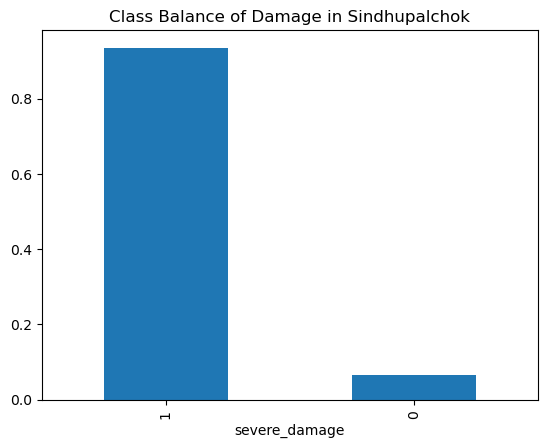

In [109]:
# Bar chart showing proportion of the binary classes in `severe_damage`
df['severe_damage'].value_counts(normalize=True).plot(kind='bar')
plt.title('Class Balance of Damage in Sindhupalchok');

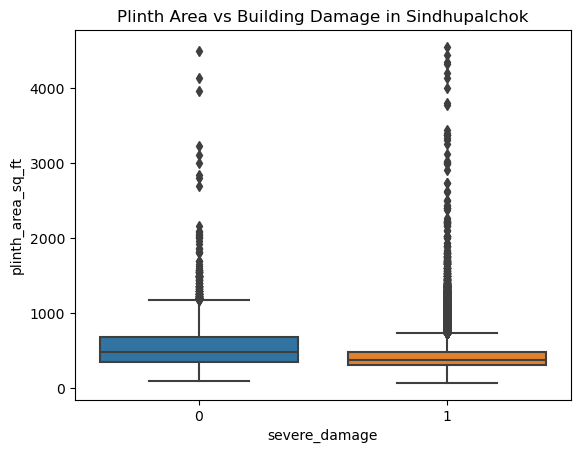

In [108]:
# Box plot showing relationship between `plinth_area_sq_ft` and `severe_damage`
sns.boxplot(df, x='severe_damage', y='plinth_area_sq_ft')
plt.title('Plinth Area vs Building Damage in Sindhupalchok');

To find out if there is materials used for building construction can lead to it being affected by the earthquake, I'll use `pandas` in-built function, `pivot_table` to find the mean of `severe_damage` for each concerned column. 

#### Roof type

In [127]:
# find the relationship between "roof_type" and "severe_damage"
pd.pivot_table(df, index='roof_type', 
               values='severe_damage', aggfunc='mean', sort=True)

,severe_damage
roof_type,
Bamboo/Timber-Heavy roof,0.976603
Bamboo/Timber-Light roof,0.950496
RCC/RB/RBC,0.271093


#### Ground floor type

In [130]:
# find the relationship between "ground_floor_type" and "severe_damage"
pd.pivot_table(df, index='ground_floor_type', 
               values='severe_damage', aggfunc='mean', sort=True)

,severe_damage
ground_floor_type,
Brick/Stone,0.959102
Mud,0.963785
Other,0.720000
RC,0.365821
Timber,0.674157


#### Foundation type

In [129]:
# find the relationship between "foundation_type" and "severe_damage"
pd.pivot_table(df, index='foundation_type', 
               values='severe_damage', aggfunc='mean', sort=True)

,severe_damage
foundation_type,
Bamboo/Timber,0.530973
Cement-Stone/Brick,0.743233
Mud mortar-Stone/Brick,0.965466
Other,0.570248
RC,0.200261


### Dataset partitioning

Partitioning the dataset into target and features

In [134]:
# seperate the target and feature columns
target = 'severe_damage'
y = df[target]

# features
X = df.drop(columns=[target])

#### Split

I'll split the dataset into training, testing sets using the `train_test_split` method in scikit-learn

In [145]:
# Train-test-split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape

(65548, 11)

In [146]:
# Extract 20% of the training set as validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train.shape

(52438, 11)

In [156]:
# Shape of training set
print(f'Shape of X_train:{X_train.shape}')
print(f'Shape of y_train:{y_train.shape}\n')

# Shape of validation set
print(f'Shape of X_val:{X_val.shape}')
print(f'Shape of y_val:{y_val.shape}\n')

# Shape of testing set
print(f'Shape of X_test:{X_test.shape}')
print(f'Shape of y_test:{y_test.shape}')

Shape of X_train:(52438, 11)
Shape of y_train:(52438,)

Shape of X_val:(13110, 11)
Shape of y_val:(13110,)

Shape of X_test:(16388, 11)
Shape of y_test:(16388,)


### Iterate

#### Baseline Model 

Calculating the basline accuracy score of the model

In [175]:
# Calculate baseline
baseline_acc = y_train.value_counts(normalize=True).max()
print(f'The baseline accuracy score is: {round(baseline_acc, 3)}')

The baseline accuracy score is: 0.936


### Iterate

In order to choose the most appropriate hyperparameters for the models max_depth, I need to iterate over a range of possible depths and choose the depth that produces the best accuracy score.

In [202]:
# Build a classification model

depth_hyperparameters = range(1, 16)

train_acc_list = []
val_acc_list = []

for d in depth:
    tune_model = make_pipeline(OrdinalEncoder(), 
                          DecisionTreeClassifier(random_state=42, max_depth=d))

    # Fit model with training data
    tune_model.fit(X_train, y_train)

    # Calculate training accuracy score
    train_acc = tune_model.score(X_train, y_train)
    train_acc_list.append(round(train_acc, 8))

    # Calculate the accuracy score of the validation set
    val_acc = tune_model.score(X_val, y_val)
    val_acc_list.append(round(val_acc, 8))
    
print(train_acc_list)
print(val_acc_list)

[0.95161905, 0.95238186, 0.95238186, 0.95385026, 0.95438423, 0.95550936, 0.95703497, 0.95819825, 0.96004806, 0.96153553, 0.96311835, 0.96491094, 0.96681796, 0.96891567, 0.97105153]
[0.95034325, 0.95179252, 0.95179252, 0.95240275, 0.95270786, 0.95247902, 0.95179252, 0.95232647, 0.95225019, 0.95179252, 0.95217391, 0.94973303, 0.94897025, 0.94874142, 0.94691076]


In [203]:
accuracy = pd.Series(val_acc_list, index=depth)
accuracy

1     0.950343
2     0.951793
3     0.951793
4     0.952403
5     0.952708
6     0.952479
7     0.951793
8     0.952326
9     0.952250
10    0.951793
11    0.952174
12    0.949733
13    0.948970
14    0.948741
15    0.946911
dtype: float64

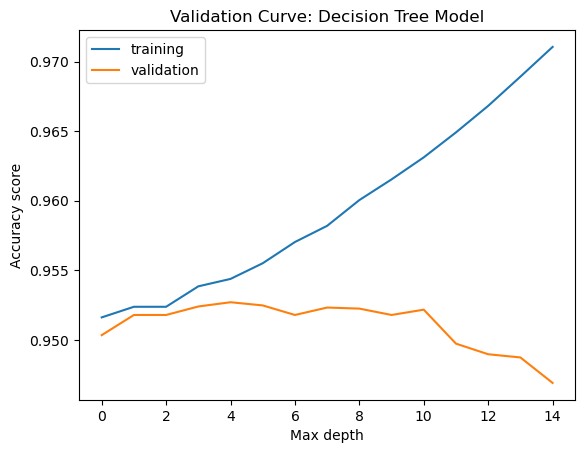

In [204]:
plt.plot(train_acc_list, label='training')
plt.plot(val_acc_list, label='validation')
plt.title('Validation Curve: Decision Tree Model')
plt.xlabel('Max depth')
plt.ylabel('Accuracy score')
plt.legend();

In [212]:
# Build model with best `max_depth`
model = make_pipeline(OrdinalEncoder(),
                     DecisionTreeClassifier(random_state=42, max_depth=10))

# fit the model with the training dataset
model.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['land_surface_condition',
                                      'foundation_type', 'roof_type',
                                      'ground_floor_type', 'other_floor_type',
                                      'position', 'plan_configuration',
                                      'superstructure'],
                                mapping=[{'col': 'land_surface_condition',
                                          'data_type': dtype('O'),
                                          'mapping': Flat              1
Moderate slope    2
Steep slope       3
NaN              -2
dtype: int64},
                                         {'col': 'foundation_type',
                                          'dat...
mud_mortar_stone/stone_flag/timber                                                                5
                                                                                               ... 
mud_mortar_stone/stone_flag/cement_mortar_stone/cement_mortar_brick/timber/rc_non_engineered    149
cement_mortar_brick/other                                                                       150
mud_mortar_stone/stone_flag/cement_mortar_stone/timber/rc_non_engineered                        151
timber/rc_non_engineered                                                                        152
NaN                                                                                              -2
Length: 153, dtype: int64}])),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=10, random_state=42))])

### Evaluate

To see how the model performs with the training set compared to the baseline accuracy score, I calculated the accuracy score of the model with test data and compare it to the baseline model.

In [215]:
acc_test = model.score(X_test, y_test)
print(f'Accuracy score with Test data: {acc_test}')
print(f'Baseline accuracy score: {baseline_acc}')

Accuracy score with Test data: 0.9517939956065413
Baseline accuracy score: 0.9358480491246806


In [250]:
model.predict(X_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

From the result, the model beats the baseline, hence it is has good performance

### Communicating result

To communicate the result in the best way, I'll use features and importances to create a plot that exposes the most important and least important features that determines the severity of the earthquakes in Sindhupalchok

In [217]:
# Feautures
features = X_train.columns
features

Index(['age_building', 'plinth_area_sq_ft', 'height_ft_pre_eq',
       'land_surface_condition', 'foundation_type', 'roof_type',
       'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration', 'superstructure'],
      dtype='object')

In [252]:
# Get the feature importances
importances = model.named_steps['decisiontreeclassifier'].feature_importances_
importances

array([0.04997717, 0.05233496, 0.0433229 , 0.00299517, 0.08529158,
       0.61471367, 0.01197873, 0.04545849, 0.01076559, 0.0098947 ,
       0.07326703])

In [225]:
feature_imp = pd.Series(importances, index=features).sort_values()
feature_imp

land_surface_condition    0.002995
plan_configuration        0.009895
position                  0.010766
ground_floor_type         0.011979
height_ft_pre_eq          0.043323
other_floor_type          0.045458
age_building              0.049977
plinth_area_sq_ft         0.052335
superstructure            0.073267
foundation_type           0.085292
roof_type                 0.614714
dtype: float64

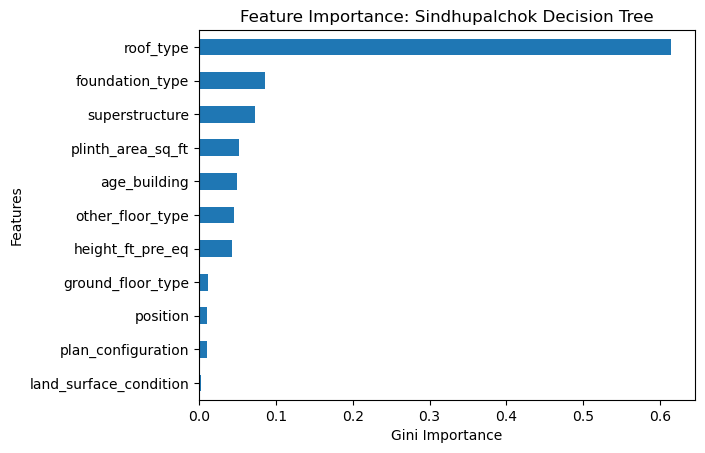

In [230]:
# Bar chart 
feature_imp.plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.title('Feature Importance: Sindhupalchok Decision Tree');

#### Tree plot

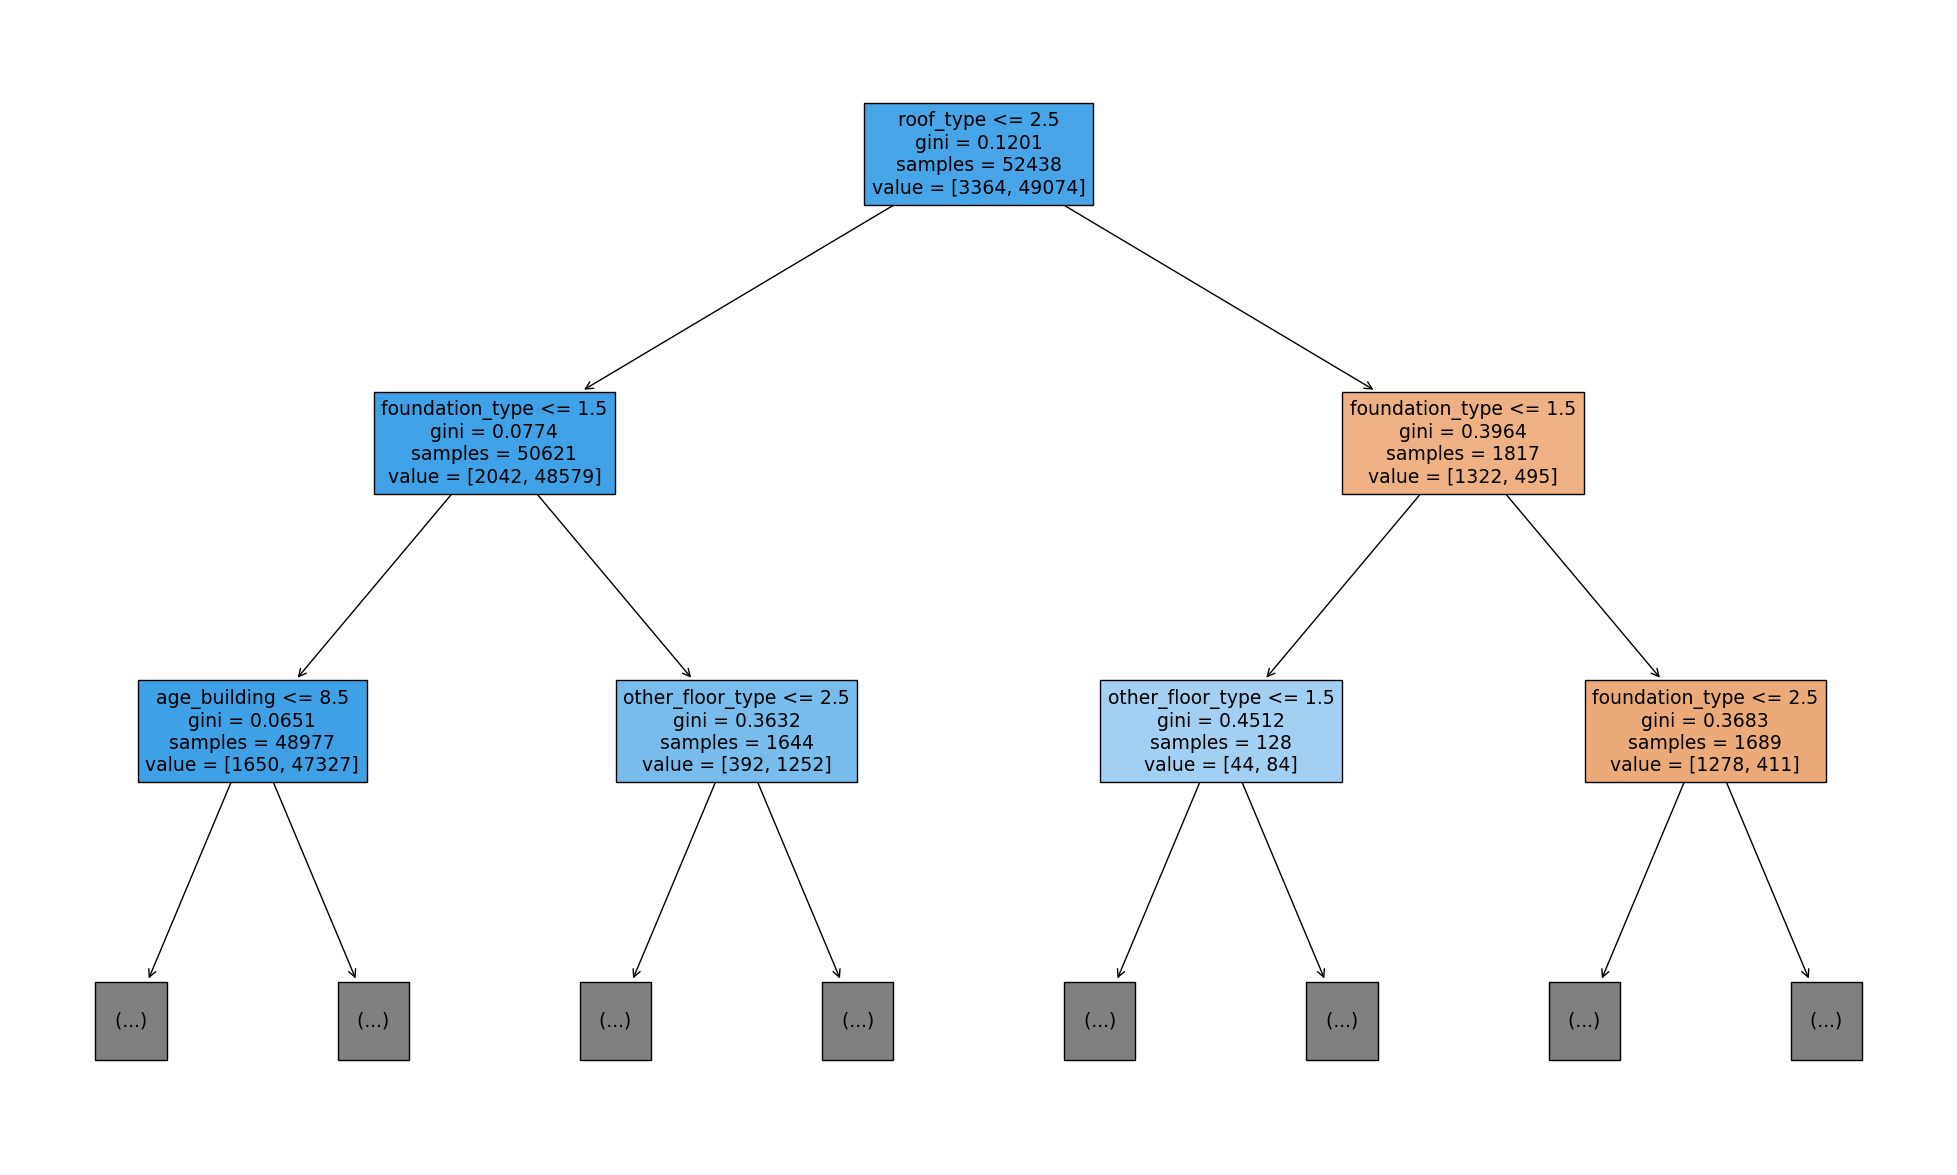

In [245]:
fig, ax = plt.subplots(figsize=(25, 15))
plot_tree(
    decision_tree=model.named_steps['decisiontreeclassifier'],
    feature_names= features,
    max_depth= 2,
    filled=True,
    rounded=False,
    precision=4,
    ax=ax
);

#### Damage Prediction function

In [310]:
# Function to make prediction
def predict_building_damage(age_building, plinth_area_sq_ft, height_ft_pre_eq, 
                          land_surface_condition, foundation_type, roof_type,
                          ground_floor_type, other_floor_type, position, 
                          plan_configuration, superstructure
                         ):
    data = {
        'age_building': age_building,
        'plinth_area_sq_ft': plinth_area_sq_ft,
        'height_ft_pre_eq': height_ft_pre_eq,
        'land_surface_condition': land_surface_condition,
        'foundation_type': foundation_type,
        'roof_type': roof_type,
        'ground_floor_type': ground_floor_type,
        'other_floor_type': other_floor_type,
        'position': position,
        'plan_configuration': plan_configuration,
        'superstructure': superstructure
    }
    
    X = pd.DataFrame(data, index=[0])
    
    severe_damage = model.predict(X)[0]

    if severe_damage == 1:
        return "Your Building will most likely suffer severe damage if an earthquake occurs"
    else:
        return 'Your building is not at risk of suffering any severe damage by an earthquake'



### Communicating Result

In [311]:
widget = interact(
            predict_building_damage,
            age_building=IntSlider(
                value= X_train['age_building'].mean(),
                min=X_train['age_building'].min(),
                max=X_train['age_building'].max()
            ),
            
            plinth_area_sq_ft=IntSlider(
                value=X_train['plinth_area_sq_ft'].mean(),
                min=X_train['plinth_area_sq_ft'].min(),
                max=X_train['plinth_area_sq_ft'].max()
            ),
        
            height_ft_pre_eq=IntSlider(
                value=X_train['height_ft_pre_eq'].mean(),
                min=X_train['height_ft_pre_eq'].min(),
                max=X_train['height_ft_pre_eq'].max()
            ),
        
            land_surface_condition=Dropdown(
                options=X_train['land_surface_condition'].unique().tolist(),
                description='Land Surface Condition',
                disabled=False
            ),
        
            foundation_type=Dropdown(
                options=X_train['foundation_type'].unique().tolist(),
                description='Foundation Type',
                disabled=False
            ),
        
        
            roof_type=Dropdown(
                options=X_train['roof_type'].unique().tolist(),
                description='Roof type',
                disabled=False
            ),
        
            ground_floor_type=Dropdown(
                options=X_train['ground_floor_type'].unique().tolist(),
                description='Ground floor type',
                disabled=False
            ),
        
            other_floor_type=Dropdown(
                options=X_train['other_floor_type'].unique().tolist(),
                disabled=False
            ),
        
                position=Dropdown(
                options=X_train['position'].unique().tolist(),
                disabled=False
            ),
        
            plan_configuration=Dropdown(
                options=X_train['plan_configuration'].unique().tolist(),
                description='Plan Configuration',
                disabled=False
            ),
        
            superstructure=Dropdown(
                options=X_train['superstructure'].unique().tolist(),
                description='Superstructure',
                disabled=False
            )
)
display(widget)

'Your Building will most likely suffer severe damage if an earthquake occurs'

interactive(children=(IntSlider(value=24, description='age_building', max=999), IntSlider(value=418, descripti…

<function __main__.predict_building_damage(age_building, plinth_area_sq_ft, height_ft_pre_eq, land_surface_condition, foundation_type, roof_type, ground_floor_type, other_floor_type, position, plan_configuration, superstructure)>

In [298]:
X_train['ground_floor_type'].unique().tolist()

['Mud', 'RC', 'Brick/Stone', 'Timber', 'Other']

In [287]:
X_train.head()

,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,superstructure
b_id,,,,,,,,,,,
237108000411,8,360,15,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,mud_mortar_stone/timber
231806001981,9,303,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,mud_mortar_stone
232707000921,88,280,13,Moderate slope,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,mud_mortar_stone
237407000191,28,364,15,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Light roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,mud_mortar_stone
232206000421,8,224,14,Flat,Mud mortar-Stone/Brick,Bamboo/Timber-Heavy roof,Mud,TImber/Bamboo-Mud,Not attached,Rectangular,mud_mortar_stone
